In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [281]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [282]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

df = pd.DataFrame(housing.data, columns=housing.feature_names)
df["SalePrice"] = housing.target
df.head() 

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,SalePrice
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   SalePrice   20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [284]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,SalePrice
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Пропусков нет

In [285]:
def train_model(df):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop("SalePrice", axis=1),
        df["SalePrice"],
        test_size=0.2, 
        random_state=0)
    lr = LinearRegression().fit(X_train, y_train)
    print(f'R2: Обучающая = {lr.score(X_train, y_train):.4f}, Тестовая {lr.score(X_test, y_test):.4f}')
    print(f'RMSE: Обучающая = {rmse(y_train, lr.predict(X_train)):.4f}, Тестовая {rmse(y_test, lr.predict(X_test)):.4f}')
    return lr
    

# Первая модель - как есть


In [286]:
lr1 = train_model(df)

R2: Обучающая = 0.6089, Тестовая 0.5943
RMSE: Обучающая = 0.7235, Тестовая 0.7273


# Вторая модель

In [287]:
def outliers_indexes(series):
    IQR = series.quantile(0.75) - series.quantile(0.25)
    upper  = series.quantile(0.75) + 1.5  * IQR
    lower   = series.quantile(0.25)  -  1.5  * IQR
    return series[(series > upper) | (series < lower)].index


Выбросы в целевой переменной

In [288]:
idx = outliers_indexes(df['SalePrice'])
df2 = df.drop(idx)

In [289]:
lr2 = train_model(df2)

R2: Обучающая = 0.5752, Тестовая 0.5586
RMSE: Обучающая = 0.6209, Тестовая 0.6384


Удаление выбросов в целевой переменной ухудшает модель. 

<Axes: >

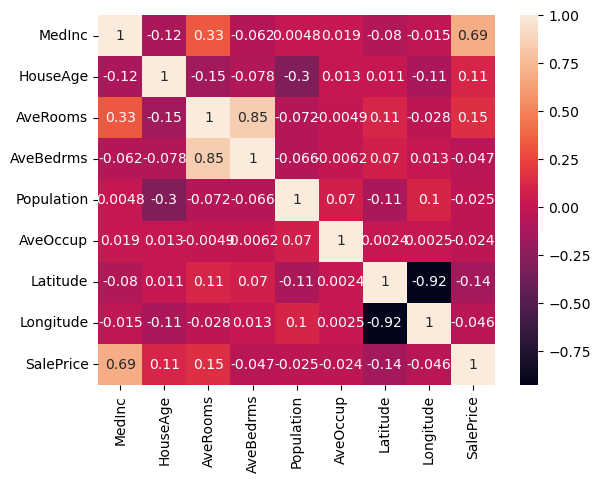

In [290]:
sns.heatmap(df.corr(), annot=True)

In [291]:
df2 = df

In [292]:
# Убираем Population
lr3 = train_model(df2.drop('Population', axis=1))

R2: Обучающая = 0.6088, Тестовая 0.5945
RMSE: Обучающая = 0.7235, Тестовая 0.7272


Тут не понятно, улучшилось или нет. R2 улучшилось, RMSE - ухудшилось. 

Пойдем дальше без этого признака. Удаление других признаков ухудшает модель

In [293]:
df2 = df2.drop('Population', axis=1)

Смотрим количество выбросов в признаках

In [294]:
for col in df2.drop('SalePrice', axis=1).columns:
    print(f'{col}: Выбросов = {len(outliers_indexes(df2[col]))}')

MedInc: Выбросов = 681
HouseAge: Выбросов = 0
AveRooms: Выбросов = 511
AveBedrms: Выбросов = 1424
AveOccup: Выбросов = 711
Latitude: Выбросов = 0
Longitude: Выбросов = 0


Удаляем выбросы

In [295]:
for col in df2.drop('SalePrice', axis=1).columns:
    idx = outliers_indexes(df2[col])
    df2.drop(idx, inplace=True)

In [296]:
lr4  = train_model(df2)

R2: Обучающая = 0.6377, Тестовая 0.6476
RMSE: Обучающая = 0.6355, Тестовая 0.6328


Сильно коррелируются AveRoom и MedInc. Попробуем поочередно удалить их

# Создаем новые признаки

Для начала построим распределение целевой переменной от признака


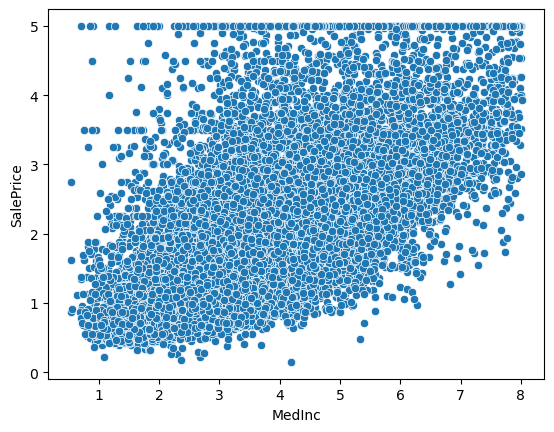

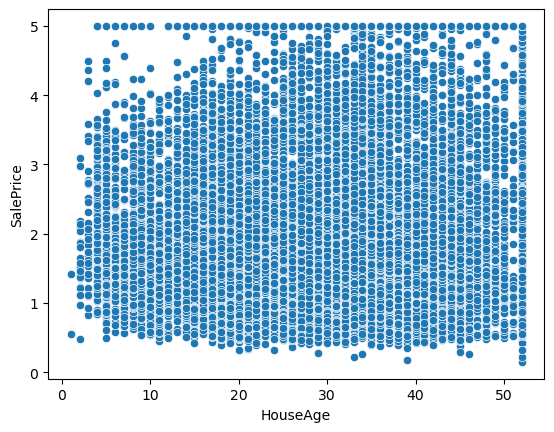

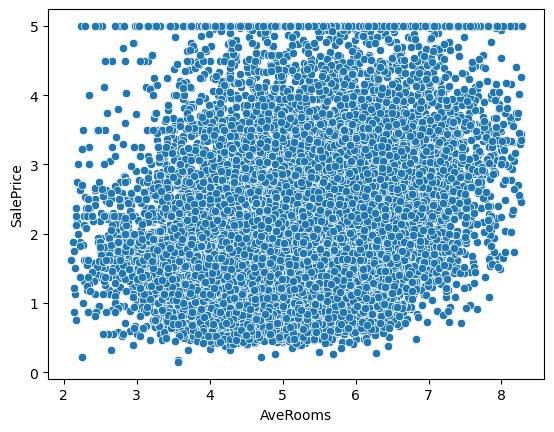

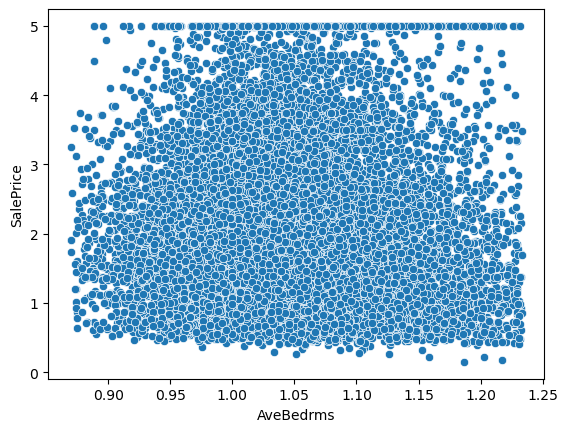

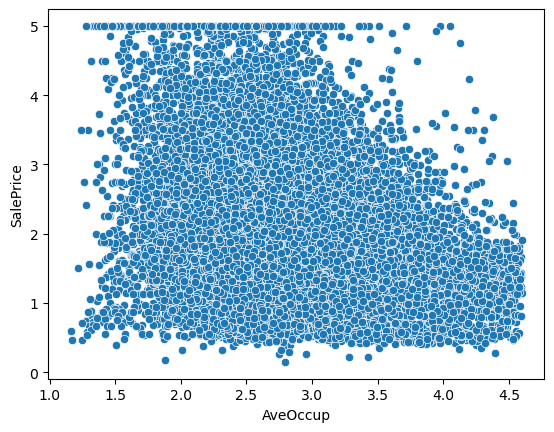

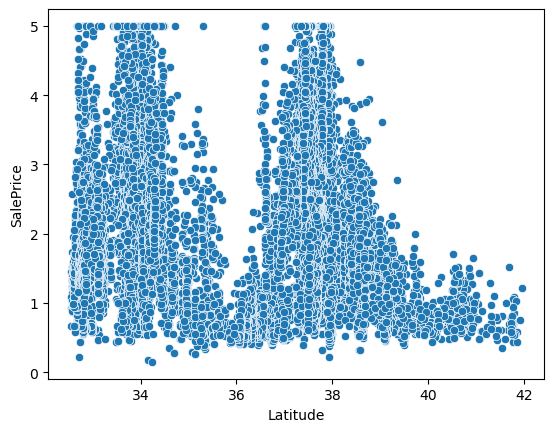

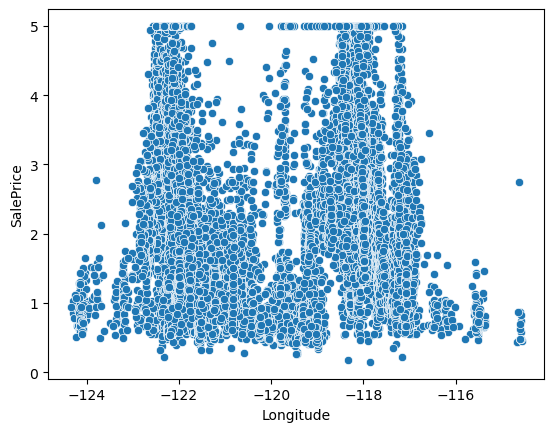

In [297]:
for col in df2.drop('SalePrice', axis=1).columns:
    sns.scatterplot(x=col, y="SalePrice", data=df2)
    plt.show()

Из графика можно увидеть, что широта и долгота чем-то напоминают полиноминальные признаки.
Попробуем внести вторую степень в модель

In [298]:
df3 = df2

In [299]:
df3['x2_lat'] = df3['Latitude'] ** 2
df2['x2_lon']  = df2['Longitude']  **  2

In [300]:
lr5  = train_model(df3)

R2: Обучающая = 0.6400, Тестовая 0.6474
RMSE: Обучающая = 0.6335, Тестовая 0.6330


Удалось получить небольшой прирост